In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
torch.manual_seed(777)
IMAGE_SIZE = 128

device='cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
  torch.cuda.manual_seed_all(777)
print(device)

cpu


이미지 부름. 변환까지 세팅
사이즈까지 교정된거 확인함.

In [4]:
original_datasets=ImageFolder(root='../data02/flower_photos',
                              transform=transforms.Compose([
                                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                transforms.ToTensor() 
                              ]))

print(original_datasets)

Dataset ImageFolder
    Number of datapoints: 2313
    Root location: ../data02/flower_photos
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


이미지를 조금씩 불러올건데
아래 코드는 배치 풀로 부름, 13개 자를건가 last 물으면 false
cuda에서 작업중이라면 num_workers로 병렬 수를 몇 개를 둘건가 세팅가능

In [5]:
original_loader=DataLoader(original_datasets, 
                           batch_size=2313,
                           shuffle=True,
                           drop_last=False,
                           num_workers=1) #데이터 로드시 사용할 병렬 프로세스 수


데이터 정보를 보자

In [6]:
for X, Y in original_loader:
  print(X.size(), Y.size())
  print(Y)

torch.Size([2313, 3, 128, 128]) torch.Size([2313])
tensor([3, 0, 4,  ..., 4, 3, 2])


출력하면 y가 수치로 나온다.
torch.Size([2313, 3, 128, 128]) torch.Size([2313])
tensor([3, 0, 4,  ..., 4, 3, 2])

3 해바라기, 0 데이티.. 레이블이 생긴거야. ㅇㅁㅇ 와우!

iter하고 next 하면 좌우 회전이든 반전이든 증강된 사진이 만들어서 저장이 됨.

In [8]:
imgs, labels = next(iter(original_loader)) #오리지날 로더를 부름
print(imgs.size(), labels.size())

torch.Size([2313, 3, 128, 128]) torch.Size([2313])


In [9]:
labels

tensor([4, 2, 1,  ..., 2, 1, 0])

라벨이 생겼어!!! 
0 데이지
1 민들레
2 장미
3 해바라기
4 튤립

뿌려보자


In [12]:
def plot(x, y):
  plt.figure(figsize=(8,10))
  for i in range(len(x)):
    plt.subplot(5,5,i+1)
    plt.title(y[i].item()) #tensor니까 item
    plt.imshow(x[i].permute(1,2,0)) #텐서(chanel, row, col) 그림을 그릴때는 aray로 있어야해.:배열(row, col, channel)
    plt.axis('off')
  plt.show()

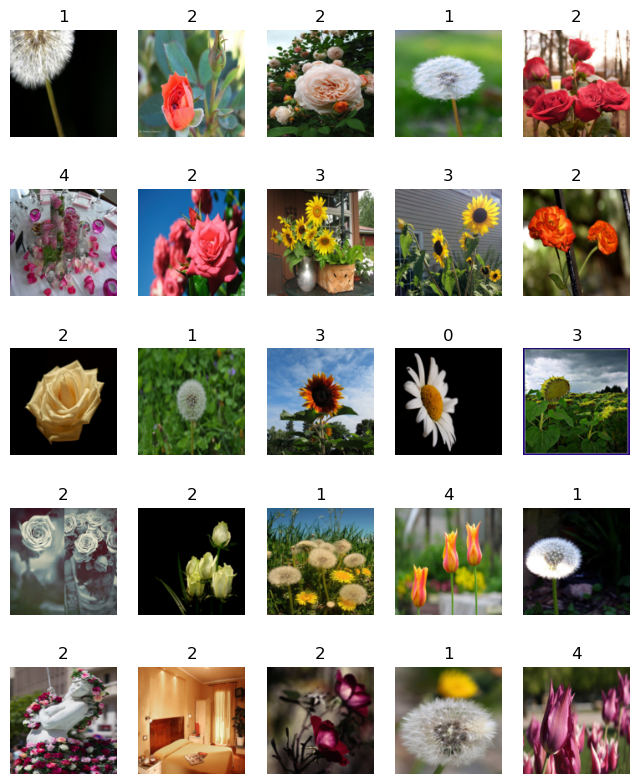

In [14]:
plot(imgs[100:125], labels[100:125])

내가 앞에 이미지데이터셋 폴더 순서대로 라벨이 만들어졌어.
폴더를 만들어서 사진을 넣고 -> 훈련데이터니까 분류가 되있어야해

이미지가 2000개 대야.
너무 작다.
이미지 증강해보자!

장수를 늘려보자


In [15]:
X1 = imgs
Y1 = labels

print(X1.size(), Y1.size())

torch.Size([2313, 3, 128, 128]) torch.Size([2313])


0번 이미지 갯수

In [16]:
Y1==0

tensor([False, False, False,  ..., False, False,  True])

데이지 꽃은 402개다.

In [17]:
(Y1==0).sum()

tensor(402)

각각의 이미지 갯수가 나와

In [18]:
cnt0=(Y1==0).sum()
cnt1=(Y1==1).sum()
cnt2=(Y1==2).sum()
cnt3=(Y1==3).sum()
cnt4=(Y1==4).sum()

print(cnt0, cnt1, cnt2, cnt3, cnt4)

tensor(402) tensor(569) tensor(433) tensor(520) tensor(389)


훈련이미지 9 : 테스트이미지1
배열로 넣어야한다.

이미지를 분류했어.

In [21]:
ratio=[0.9, 0.1]
train_cnt=int(Y.size(0)*ratio[0])
test_cnt=int(Y.size(0)*ratio[1])

cnts=[train_cnt, test_cnt]
print(cnts[0], cnts[1])

2081 231


지금도 섞여 있지만 순서 한번 더 섞음

train/test 나눔

In [ ]:
indices=torch.randperm(X1.size(0))
x=torch.index_select(X1, dim=0, index=indices) #행으로 끊게 dim=0
y=torch.index_select(Y1, dim=0, index=indices)

#train/test data 나눔

x_train=x[:cnts[0]]
x_test=x[cnts[0]:] #2081~나머지

y_train=y[:cnts[0]] #0번까지
y_test=y[cnts[0]:]

print(x_train.size(), y_train.size(), x_test.size(), y_test.size())


torch.Size([2081, 3, 128, 128]) torch.Size([2081]) torch.Size([232, 3, 128, 128]) torch.Size([232])


나누었고, 실제로 train 할때 x+y 데이터 합본 만들기

데이터 셋 만들고

데이터셋 로드

데이터셋 만드는거야 이건!!

In [24]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader=DataLoader(train_dataset,
                        batch_size=100,
                        shuffle=True,
                        drop_last=False)


test_loader=DataLoader(test_dataset,
                        batch_size=100,
                        shuffle=True,
                        drop_last=False)



In [26]:
for X, Y in train_loader:
  print(X.size(), Y.size())

torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([81, 3, 1

In [25]:
for X, Y in test_loader:
  print(X.size(), Y.size())

torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([100, 3, 128, 128]) torch.Size([100])
torch.Size([32, 3, 128, 128]) torch.Size([32])


CNN 클래스 만들기
그림이 커서 높게 쌓을 수 있지만 속도 문제가 있어.
75% 정도 되게끔? 하신데?

In [27]:
class CNN(nn.Module):
  def __init__(self): #init은 모델을 정의하는 과정
    super().__init__() # super(CNN, self).__init__() 해도 되고, 안해도 되고
    # 컨볼루션 쫙 - 폴링 쫙 - forward에서 구현하는 형태
    # 처음 시작 (3, 128, 128) => 
    self.conv1=nn.Conv2d(3, 8, 3, padding=1) # (3, 128, 128)->(8, 64, 64) /단 쌓을 거라서 출력은 8 채널, 출력, 커널, 스트라이드 생략, 패딩
    self.conv2=nn.Conv2d(8, 16, 3, padding=1) # (8, 64, 64) -> (16, 32, 32)
    self.conv3=nn.Conv2d(16, 32, 3, padding=1) # (16, 32, 32) -> (32,16,16)
    self.conv4=nn.Conv2d(32, 64, 3, padding=1) # (32, 16, 16) -> (64,8,8)
    self.conv5=nn.Conv2d(64, 128, 3, padding=1) # (64, 8, 8) -> (128,4,4) 

    self.pool=nn.MaxPool2d(kernel_size=2, stride=2)  #MaxPool2d 2d라서 ?? ㅇㅁㅇ?? 이게 뭘까

  #fc는 완전 연결층 - 1차원으로 펼친 것, 출력은 128로 했는데 정하기 나름?
    self.fc1=nn.Linear(128*4*4, 128)
    self.fc2=nn.Linear(128, 64)
    self.fc3=nn.Linear(64,5) # 5개의 꽃 종류가 출력되게

  def forward(self, x):
    x=self.conv1(x) #out이든 x든 갠찮
    x=torch.relu(x) #relu 대문자든 소문자든 of
    x=self.pool(x)

#for문 돌려도 되는데 지금은 복사

    x=self.conv2(x) 
    x=torch.relu(x) 
    x=self.pool(x)

    x=self.conv3(x) 
    x=torch.relu(x) 
    x=self.pool(x)

    x=self.conv4(x) 
    x=torch.relu(x) 
    x=self.pool(x)

    x=self.conv5(x) 
    x=torch.relu(x) 
    x=self.pool(x)        

#특징을 찾는 컨볼루전 과정 끝 이미지 만들자.

    x=x.view(-1, 4*4*128) 
    x=self.fc1(x)
    x=self.fc2(x)
    x=self.fc3(x)

    #원래는 소프트맥스 넣어야하지만 생략가능, 생략하고

    return x
     





이미지 분류는 CNN이 기본이고 어떤 형태로 망을 구축하는지 rest net같은거 cnn 기본
어떻게 단을 쌓고, 필터를 어떻게 끼우는가 따라서 여러 모델이 나와있어. <ㅡ ㅇㅁㅇ 꺄악!!

시중의 모델을 그냥 써도 되지만 자세히 봐라.

아래 모델을 한번 보자

In [44]:
model = CNN().to(device) #cnn 자체가 클래스라서 객체를 만들어야해
print(model)
optimizer = optim.Adam(model.parameters()) #러닝메이트 안써도 알아서 해줘. lr 쓰면 초기 러닝메이트고 나머지는 adam이 알아서 세팅
crit=nn.CrossEntropyLoss() #소프트 맥스의 결과로 한다. 이거 해서 위에 소프트 맥스 생략
#citi=nn.NLLLoss() 이거 쓰는 경우 위에 소프트맥스 살려야해

#파라미터 출력 - 입력값만큼 w가 생겼고 tensor([-0.0404,  0.0949, -0.0199,  0.1218,  0.0972], 5개가 나온 것은 출력값이 5개라서

print(list(model.parameters()))


CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)
[Parameter containing:
tensor([[[[-0.0389, -0.0160, -0.1577],
          [-0.1578, -0.1388, -0.0891],
          [ 0.0949, -0.0451,  0.0306]],

         [[-0.0961, -0.1192, -0.1719],
          [-0.1511,  0.0181,  0.1635],
          [ 0.0095,  0.0931, -0.1011]],

         [[-0.1246,  0.0819, -0.1365],
          [ 0.0046, -0.0153, -0.1586],
   

훈련을 시켜보자

데이터가 너무 작아. 검정데이터를 테스트 데이터로 해서 훈련과 검정을 동시에

트레이닝부분 만들자!

In [ ]:
def train(model, train_loader, optimizer):
  model.train() #훈련모드 선언!

  # for batch_index,(img, label) in train_loader: #x와 y만 나오는데 
  for batch_index,(img, label) in enumerate(train_loader): #이넘 붙으면 인덱스까지 만들어진데 무슨말이지?
    img = img.to(device)
    label=label.to(device)

    optimizer.zero_grad()
    y_hat=model(img)
    loss=crit(y_hat, label)
    loss.backward()
    optimizer.step()

    if batch_index%10==0: #100개씩 데이터를 한번 읽을때, 10번마다 찍어
      print(f'train epoch:{epoch}, train Loss:{loss.item()}') #지금은 epoch 에러나지만 밑에 실행하고 다시 실행하면 괜춘
      #트레이닝 손실함수 출력


In [45]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad(): #기울기 미분하지말고
    for img, label in test_loader:
      img=img.to(device)
      label=label.to(device)
      y_hat=model(img)
      test_loss+=crit(y_hat, label).item() # test 손실함수를 구해서 같이 출력

      pred=y_hat.argmax(dim=-1) #한 행에 5개의 값이 나와. 1을 하던 -1하던 상관 없어
      correct+=(pred==label).sum()
    
  test_loss=test_loss/len(test_loader.dataset)
  test_accuracy = correct/len(test_loader.dataset)*100 
  return test_loss, test_accuracy




얼리스탑넣기

In [ ]:
from copy import deepcopy

epochs = 200
early_stop=10 #빨리 보려고 10한거고 실제로는 100 하면 됨
lowest_loss=np.inf
lowest_epoch=np.inf
best_model=None

#지난번에는 모델을 변수에 넣기만 했는데 저장을 하면 불러서 쓸수있다.
path="../data02/model.pt" #모델 저장할때 확장자 명은 pt

출력부분

In [47]:
for epoch in range(epochs):
  train(model, train_loader, optimizer)

  test_loss, test_accuracy=evaluate(model, test_loader)
  print(f'epoch:{epoch}, test loss:{test_loss}, test_accuracy:{test_accuracy}')
  #  print('Epoch:{:4d}/{}, Test Loss:{:.6f}, Test Accuracy:{}'.format(epoch, epochs, test_loss, test_accuracy))

  #얼리스탑

  if test_loss < lowest_loss:
    lowest_loss=test_loss
    lowest_epoch=epoch #현재의 에폭
    best_model=deepcopy(model) #이 페이지에서 바로 쓸때 쓰는데 이거 나중에 저장해서 쓰고 싶으면 불러써
    torch.save(model.state_dict(), path) #이 상태에서 모델을 저장

  else:
    if early_stop >0 and lowest_epoch + early_stop<epoch: #테스트의 최소cost를 
      print(f'{lowest_epoch} 이후에 {early_stop} 증가되는 동안 손실함수 감소가 없음')
      break

print(f'{lowest_epoch}일 때 손실함수의 값이 {lowest_loss}로 가장 낮음')

trin epoch:0, train Loss:1.6118173599243164
trin epoch:0, train Loss:1.578752875328064
trin epoch:0, train Loss:1.5765382051467896
epoch:0, test loss:0.0196342159961832, test_accuracy:31.89655303955078
trin epoch:1, train Loss:1.5215883255004883
trin epoch:1, train Loss:1.3523495197296143
trin epoch:1, train Loss:1.3144036531448364
epoch:1, test loss:0.016930507174853622, test_accuracy:43.10344696044922
trin epoch:2, train Loss:1.2474653720855713
trin epoch:2, train Loss:1.2061976194381714
trin epoch:2, train Loss:1.232875108718872
epoch:2, test loss:0.014778938272903705, test_accuracy:50.86206817626953
trin epoch:3, train Loss:0.9843165874481201
trin epoch:3, train Loss:1.0507434606552124
trin epoch:3, train Loss:1.0232287645339966
epoch:3, test loss:0.014337253467790011, test_accuracy:49.13793182373047
trin epoch:4, train Loss:1.063999891281128
trin epoch:4, train Loss:0.9587291479110718
trin epoch:4, train Loss:1.112339973449707
epoch:4, test loss:0.013626003573680746, test_accuracy

얼리스톱 쓰는 이유
-기울기 0까지 찾을 필요가 없다.
75 언저리에서 더이상 움직이지 않아

test로 검정을 하고 얼마 이상 더 좋은거 안나오면 stop 하고 best model 을 받아가

얼리스탑 에폭을 test니까 50을 줬지 실제는 100 정도 준다

-> 넣었고, 빨리보려서 10줬어

In [35]:
prediction=model(x_test[1].to(device)).argmax(dim=-1) #1번 데이터를 훈련된 모델로 넣어보겠다.
print(prediction.item(), y_test[1].item())

0 2


그림으로도 표시해보자

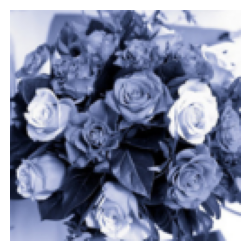

In [36]:
plt.figure(figsize=(3,3))
plt.imshow(x_test[1].permute(1, 2, 0))
plt.axis('off')
plt.show()

In [40]:
prediction=model(x_test[0].to(device)).argmax(dim=-1) #1번 데이터를 훈련된 모델로 넣어보겠다.
print(prediction.item(), y_test[0].item())

3 3


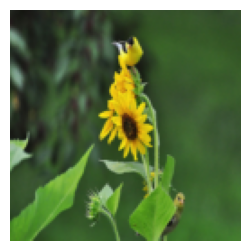

In [41]:
plt.figure(figsize=(3,3))
plt.imshow(x_test[0].permute(1, 2, 0))
plt.axis('off')
plt.show()

In [38]:
prediction=model(x_test[10].to(device)).argmax(dim=-1) #1번 데이터를 훈련된 모델로 넣어보겠다.
print(prediction.item(), y_test[10].item())

0 4


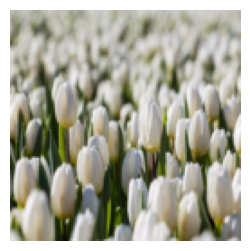

In [39]:
plt.figure(figsize=(3,3))
plt.imshow(x_test[10].permute(1, 2, 0))
plt.axis('off')
plt.show()

In [42]:
prediction=model(x_test[2].to(device)).argmax(dim=-1) #1번 데이터를 훈련된 모델로 넣어보겠다.
print(prediction.item(), y_test[2].item())

1 1


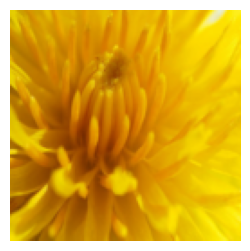

In [43]:
plt.figure(figsize=(3,3))
plt.imshow(x_test[2].permute(1, 2, 0))
plt.axis('off')
plt.show()

베스트모델로 불러오고

파일도 불러오고


In [48]:
prediction=best_model(x_test[2].to(device)).argmax(dim=-1) #1번 데이터를 훈련된 모델로 넣어보겠다.
print(prediction.item(), y_test[2].item())

3 1


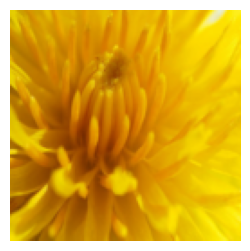

In [49]:
plt.figure(figsize=(3,3))
plt.imshow(x_test[2].permute(1, 2, 0))
plt.axis('off')
plt.show()

In [50]:
prediction=best_model(x_test[10].to(device)).argmax(dim=-1) #1번 데이터를 훈련된 모델로 넣어보겠다.
print(prediction.item(), y_test[10].item())

0 4


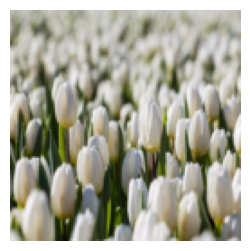

In [51]:
plt.figure(figsize=(3,3))
plt.imshow(x_test[10].permute(1, 2, 0))
plt.axis('off')
plt.show()

이미지 갯수가 많아지면 오버피팅이 줄어들어. test로도 손실함수가 줄어들수도 있다는 말(?????)

어떤 epoch을 해야할지 모를때, eraly stop 하면 도움이 됨.
100번 정도는 해야해.


저장한 모델 불러오기
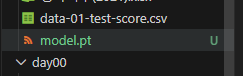

In [52]:
model1=CNN().to(device)
model1.load_state_dict(torch.load('../data02/model.pt'))

model1


CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)

위처럼 우리가 사용한 모델이 읽힌다.

사용은 아래와 같이 한다.

In [57]:
pred = model1(x_test[0])
print(torch.argmax(pred, -1), y_test[0])


tensor([1]) tensor(3)


In [61]:
pred = model1(x_test[5])
print(torch.argmax(pred, -1), y_test[5])

tensor([0]) tensor(0)
